# Graph Partition

This notebook is about some classical Graph Partition Algorithm, like 

- Degree-based heuristics (DBH), 
- Greedy Algorithm
- HDRF Algorithm. 

They focus on edge-partition (which is also known as vertex-cut).

Max degree: 49999
Min degree: 2
Avg degree: 16.5


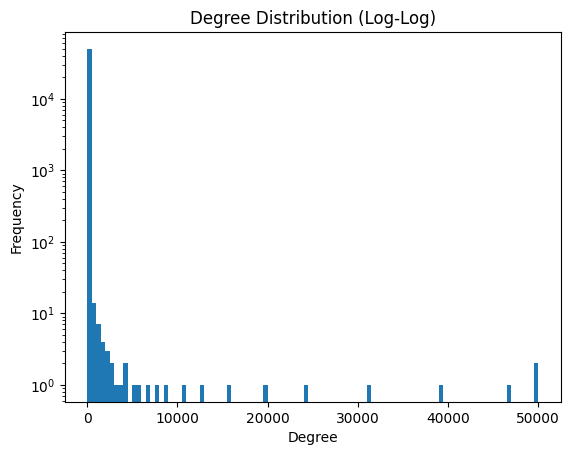


Sample edge stream:
Edge arrived: (6, 7511)
Edge arrived: (31, 28509)
Edge arrived: (4, 7438)
Edge arrived: (4, 49317)
Edge arrived: (5, 27288)
Edge arrived: (6, 36558)
Edge arrived: (9, 43245)
Edge arrived: (5, 14456)
Edge arrived: (4, 36485)
Edge arrived: (6, 23726)
Naive partition replication factor: 9.27704
HDRF replication factor: 1.70882


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import random
# Expected Running Time: 2 min, 50k Nodes, 1M edges.

def generate_powerlaw_edges(num_nodes=500, num_edges=10000, zipf_param=2, seed=42):
    """
    生成符合幂律分布的边流
    参数：
        num_nodes: 总节点数（默认1000）
        num_edges: 生成边数（默认10000）
        zipf_param: Zipf分布参数（越大幂律越陡，建议1.5-2.5）
        seed: 随机种子
    返回：
        edges: 边流列表 [(src, dst), ...]
    """
    np.random.seed(seed)
    
    # 生成源节点和目标节点
    src_nodes = (np.random.zipf(zipf_param, 2*num_edges) % num_nodes) + 1
    dst_nodes = (np.random.randint(1, num_nodes+1, 2*num_edges))
    
    edges_set = set()
    for s, d in zip(src_nodes, dst_nodes):
        if s != d:
            edges_set.add((min(s, d).item(), max(s, d).item()))
        if len(edges_set) >= num_edges:
            break
    
    return list(edges_set)[: num_edges + 1]  # 确保输出数量准确

def analyze_distribution(edges):
    """分析节点度数分布"""
    node_counts = Counter()
    for s, d in edges:
        node_counts[s] += 1
        node_counts[d] += 1
    
    degrees = list(node_counts.values())
    print(f"Max degree: {max(degrees)}")
    print(f"Min degree: {min(degrees)}")
    print(f"Avg degree: {sum(degrees)/len(degrees):.1f}")

    # 绘制分布图
    plt.hist(degrees, bins=100, log=True)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution (Log-Log)')
    plt.show()
    
def get_replication_factor(partitions, edges):
    """
    计算边分割方案的复制因子，并验证分割方案的完整性和合法性
    
    参数：
        partitions: list(list(tuple(int, int))) - 边分割方案，每个子列表为一个分区的边集合
        edges: list(tuple(int, int)) - 原始图的完整边列表
    
    返回：
        float - 复制因子RF值
    
    异常：
        ValueError - 当分割方案不完整或存在非法边时抛出
    """
    # 预处理原始边（标准化为无重复的无向边集合）
    original_edges = set()
    for e in edges:
        if len(e) != 2 or not all(isinstance(v, int) for v in e):
            raise ValueError(f"非法边格式：{e}")
        s, t = sorted(e)
        if s == t:
            raise ValueError(f"自环边不允许：{e}")
        original_edges.add((s, t))
    total_original = len(original_edges)

    # 预处理分区边（合并并标准化）
    partitioned_edges = set()
    for i, p in enumerate(partitions):
        if not isinstance(p, list):
            raise ValueError(f"分区{i}不是列表类型")
        for e in p:
            if len(e) != 2 or not all(isinstance(v, int) for v in e):
                raise ValueError(f"分区{i}中的非法边：{e}")
            s, t = sorted(e)
            if (s, t) in partitioned_edges:
                raise ValueError(f"边重复：({s}, {t}) 跨分区重复")
            partitioned_edges.add((s, t))

    # 验证完整性
    missing = original_edges - partitioned_edges
    if missing:
        example = next(iter(missing))
        raise ValueError(f"缺失边示例：{example} (共缺失{len(missing)}条)")
    
    extra = partitioned_edges - original_edges
    if extra:
        example = next(iter(extra))
        raise ValueError(f"多余边示例：{example} (共多余{len(extra)}条)")

    # 计算顶点全集（基于原始边）
    all_vertices = set()
    for s, t in original_edges:
        all_vertices.update({s, t})
    total_vertices = len(all_vertices)
    if total_vertices == 0:
        return 0.0

    # 计算各分区的顶点数
    sum_replicated = 0
    for p in partitions:
        vertices = set()
        for s, t in p:
            vertices.update({s, t})
        sum_replicated += len(vertices)

    # 返回复制因子
    rep_factor = sum_replicated / total_vertices
    return rep_factor

def dbh_streaming_partition(edges, K=30):
    """
    DBH algorithm implementation for streaming edge partitioning.
    
    Parameters:
        edges (list of tuples): Stream of input edges as (u, v) pairs
        K (int): Number of partitions (default: 30)
    
    Returns:
        tuple: (partitions, replication_factor)
            - partitions: List of K partitions containing edges
            - replication_factor: Calculated replication factor
    """
    # Initialize data structures
    partitions = [[] for _ in range(K)]      # Partition containers
    degree_counter = defaultdict(int)        # Vertex degree tracker
    vertex_partitions = defaultdict(set)     # Track which partitions contain each vertex
    
    # Process each edge in the stream
    for u, v in edges:
        # Get current degrees of both vertices
        deg_u = degree_counter[u]
        deg_v = degree_counter[v]
        
        # --- DBH Core Logic ---
        # 1. Anchor Selection: Choose vertex with higher degree
        if deg_u > deg_v:
            anchor = u
        elif deg_v > deg_u:
            anchor = v
        else:
            # Tiebreaker: Select vertex with larger ID when degrees are equal
            anchor = max(u, v)
        
        # 2. Partition Assignment: Hash anchor to determine partition
        partition = hash(anchor) % K
        
        # --- Update Metadata ---
        # Add edge to selected partition
        partitions[partition].append((u, v))
        
        # Update vertex degrees (both endpoints gain a degree)
        degree_counter[u] += 1
        degree_counter[v] += 1
        
        # Track vertex presence in partitions
        vertex_partitions[u].add(partition)
        vertex_partitions[v].add(partition)
    
    # --- Calculate Replication Factor ---
    rf = get_replication_factor(partitions, edges)
    print(f"DBH streaming algorithm replication factor: {rf}")
    return partitions, rf

def greedy_streaming_partition(edges, K=30, epsilon=0.1):
    """
    Greedy streaming graph partitioning algorithm implementation
    
    Parameters:
        edges (list of tuples): Input edge stream [(u, v), ...]
        K (int): Number of partitions
        epsilon (float): Balance term coefficient
    
    Returns:
        list of lists: Partitions [[(u, v), ...], ...]
    """
    # Initialize data structures
    partitions = [[] for _ in range(K)]               # Final edge containers
    vertex_partitions = defaultdict(set)               # A(v): vertex -> set of partitions
    partition_sizes = [0] * K                          # Current size of each partition
    
    # Process each edge in the stream
    for u, v in edges:
        # Get current assignments
        u_partitions = vertex_partitions[u]
        v_partitions = vertex_partitions[v]
        
        # Case determination
        if not u_partitions and not v_partitions:     # Case 1
            candidate_partitions = range(K)
        elif not u_partitions or not v_partitions:    # Case 2
            anchor = u if u_partitions else v
            candidate_partitions = vertex_partitions[anchor]
        elif u_partitions & v_partitions:             # Case 3
            candidate_partitions = u_partitions & v_partitions
        else:                                          # Case 4
            candidate_partitions = u_partitions | v_partitions
        
        # Compute scores for candidate partitions
        max_size = max(partition_sizes)
        min_size = min(partition_sizes) if partition_sizes else 0
        balance_scale = epsilon * (max_size - min_size) / (min_size + 1e-8)
        
        best_score = -float('inf')
        best_partitions = []
        
        for p in candidate_partitions:
            # Replication term
            rep_term = (p in u_partitions) + (p in v_partitions)
            
            # Balance term
            current_size = partition_sizes[p]
            balance_term = balance_scale * (max_size - current_size) / (current_size + 1e-8)
            
            # Total score
            score = rep_term + balance_term
            
            # Update best candidates
            if score > best_score:
                best_score = score
                best_partitions = [p]
            elif score == best_score:
                best_partitions.append(p)
        
        # Tiebreaker: select partition with smallest size
        if not best_partitions:  # Handle empty candidate case
            best_partitions = [random.randint(0, K-1)]
            
        selected = min(best_partitions, key=lambda x: partition_sizes[x])
        
        # Assign edge to partition
        partitions[selected].append((u, v))
        partition_sizes[selected] += 1
        
        # Update vertex assignments
        vertex_partitions[u].add(selected)
        vertex_partitions[v].add(selected)
    rf = get_replication_factor(partitions, edges)
    print(f"Greedy Algorithm replication factor: {rf}")
    return partitions

from collections import defaultdict

def hdrf_partition(edges, K=30, lambda_=0.4):
    # 初始化数据结构
    delta = defaultdict(int)          # 顶点的部分度数
    A = defaultdict(set)              # 顶点副本所在的分区集合
    partitions = [[] for _ in range(K)]  # 存储每个分区的边
    sizes = [0] * K                   # 各分区当前边数
    epsilon = 1e-6                    # 防止除零的小常数

    for e in edges:
        s, t = e
        # 更新部分度数
        delta[s] += 1
        delta[t] += 1
        
        # 计算归一化度数
        total_degree = delta[s] + delta[t]
        theta_s = delta[s] / total_degree
        theta_t = delta[t] / total_degree
        
        # 计算所有分区的得分
        max_size = max(sizes)
        min_size = min(sizes)
        scores = []
        for p in range(K):
            # 计算复制优化项 C_REP
            g_s = 1 + (1 - theta_s) if p in A[s] else 0
            g_t = 1 + (1 - theta_t) if p in A[t] else 0
            C_REP = g_s + g_t
            
            # 计算负载均衡项 C_BAL
            bal_numerator = max_size - sizes[p]
            bal_denominator = epsilon + max_size - min_size
            C_BAL = lambda_ * bal_numerator / bal_denominator
            
            scores.append(C_REP + C_BAL)
        
        # 选择得分最高的分区
        p_star = scores.index(max(scores))
        
        # 分配边到分区并更新状态
        partitions[p_star].append(e)
        sizes[p_star] += 1
        
        # 记录顶点在该分区的副本
        A[s].add(p_star)
        A[t].add(p_star)

    rf = get_replication_factor(partitions, edges)
    print(f"HDRF replication factor: {rf}")
    return partitions

if __name__ == "__main__":
    num_nodes = 50000
    num_edges = 1000000
    num_partition = 800
    # 生成示例数据
    edges = generate_powerlaw_edges(num_nodes=num_nodes, num_edges=num_edges, zipf_param=2)

    # 分析验证
    analyze_distribution(edges)

    # 输出前10条边模拟流式到达
    print("\nSample edge stream:")
    for e in edges[:10]:
        print(f"Edge arrived: {e}")
    
    result = [[] for _ in range(num_partition)]
    for i in range(len(edges)):
        idx =  i % num_partition 
        result[idx].append((edges[i][0], edges[i][1]))
    
    # result = [[(1,2), (2,3)], [ (1,4), (2,5), (4,5), (1,3)]]
    # edges = [(1,2), (2,3), (1,4), (2,5), (4,5), (1,3)]
    
    rep_factor = get_replication_factor(result, edges)
    print(f"Naive partition replication factor: {rep_factor}")
    dbh_streaming_partition(edges, K = num_partition)
    greedy_streaming_partition(edges, K = num_partition)
    hdrf_partition(edges, K = num_partition)